# osm_LoD1_3DCityModel Walkthrough

**The purpose of this notebook is to walk a user through [osm_LoD1_3DCityModel](https://github.com/AdrianKriger/osm_LoD1_3DCityModel/tree/main/village_campus).**


<div class="alert alert-block alert-warning"><b>This notebook will:</b>

> **1. allow the user to create a Level-of-Detail 1 (LoD1) [3D City Model](https://en.wikipedia.org/wiki/3D_city_model).**  
>
> **2. propose several [Geography and Sustainable Development Education *conversation starters*](#Section2) for Secondary and Tertiary level students**
</div>

<div class="alert alert-block alert-danger"><b></b>

***The [suburb](https://github.com/AdrianKriger/geo3D/tree/main/suburb)*** processing option is meant for areas with more than for **2 500 buildings**.</div>

In [1]:
#- load the magic
import time
from datetime import timedelta
import tempfile

import os
from itertools import chain
import math
import fiona
import requests
import copy
import json
import overpass
#import osm2geojson
import numpy as np
import pandas as pd
#import geopandas as gpd
import topojson as tp

import shapely
from shapely.geometry import Point, Polygon, MultiPolygon, polygon, shape
from shapely.ops import snap, transform
from shapely.strtree import STRtree

import city3D

import pyproj
from osgeo import gdal, ogr, osr

import triangle as tr

from openlocationcode import openlocationcode as olc

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon
from matplotlib.collections import PatchCollection

/Users/adriankriger/miniconda3/envs/geo3D_gthbRepo07/lib/python3.9/site-packages/cjio/cityjson.py:12: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


In [2]:
Tstart = time.time()

import warnings
warnings.filterwarnings('ignore')

**A `parameter.json` defines the path and files**.

In [3]:
jparams = json.load(open('wStock_param.json'))       
#jparams = json.load(open('uEstate_param.json'))   
#jparams = json.load(open('sRiver_param.json'))   
#jparams = json.load(open('saao_param.json'))   

**Harvest [OpenStreetMap](https://en.wikipedia.org/wiki/OpenStreetMap)** - interogate an osm.pbf (["Protocolbuffer Binary Format"](https://wiki.openstreetmap.org/wiki/PBF_Format)) from within Jupyter and convert to .geojson.

<div class="alert alert-block alert-info"><b></b> 
    
**PLEASE SUPPLY YOUR OWN [osm.pbf](https://wiki.openstreetmap.org/wiki/PBF_Format).**  

**Either crop an area directly from [OpenStreetMap]() with the ***[official tool](https://www.openstreetmap.org/export#map=3/0.70/22.15)***, select a predefined area [from any number of providers](https://wiki.openstreetmap.org/wiki/Planet.osm), such as ***[Geofabrik](https://download.geofabrik.de)***, or...**
</div>

<div class="alert alert-block alert-success"><b></b>
    
**... download your own. Provincial extracts for South Africa are available here:** *http://download.openstreetmap.fr/extracts/africa/south_africa/*</div>

In [4]:
# Input OSM PBF file
input_pbf = "./data/CapeTown.osm.pbf"

# GeoPackage file [will be created]
#output_gpkg = "./data/output_polygons.gpkg"

**Lets first harvest the boundary of the area; we want to interogate**

In [5]:
#- get the area [suburb]
query = """[out:json][timeout:30];
        area[boundary=administrative][name='{0}'] -> .a;
        (
        way[amenity~'university|research_institute'][name='{1}'](area.a);
        relation[place][place~"sub|town|city|count|state|village|borough|quarter|neighbourhood"][name='{1}'](area.a);
        );
        out geom;
        """.format(jparams['LargeArea'], jparams['FocusArea'])

#url = "http://overpass-api.de/api/interpreter"
#r = requests.get(url, params={'data': query})
#rr = r.read()
#area = osm2geojson.json2geojson(r.json())
#read into .gpd
#aoi = gpd.GeoDataFrame.from_features(area['features'])
#aoi = aoi.set_crs(4326, allow_override=True)
#if jparams['osm_type'] == 'relation' and len(aoi) > 1:
#    for i, row in aoi.iterrows():
#        if row.tags != None and 'place' in row.tags:
#            focus = row
            
#    trim = pd.DataFrame(focus)
#    trim = trim.T
#    aoi = gpd.GeoDataFrame(trim, geometry = trim['geometry'])
    #aoi = aoi.set_crs(4326)

# Drop rows where geometry is None or NaN
#aoi = aoi.dropna(subset=['geometry'])
#aoi = aoi.set_crs(4326, allow_override=True)

#- execute function from city3D and and return GeoDataFrameLite | home-baked gdf
aoi = city3D.overpass_to_gdf(query)

#- suppose 'aoi' is your GeoDataFrameLite or list of geometries
geoms = aoi['geometry'].tolist()
#- combine all geometries into a single union
combined_geom = shapely.unary_union(geoms)  # returns Polygon or MultiPolygon
#- compute bounding box
minx, miny, maxx, maxy = combined_geom.bounds
#extent = [minx - 250, miny - 250,maxx + 250, maxy + 250]
aoi.head(2)

,boundary,name,place,type,wikidata,geometry,osm_id,osm_type
0,place,Woodstock,suburb,boundary,Q3644460,"POLYGON ((18.4407807 -33.9286635, 18.4408288 -...",2034285,relation


**Only harvest what we need from the osm.pbf.**

In [6]:
start = time.time()

gdal.UseExceptions()
gdal.SetConfigOption("OGR_GEOMETRY_ACCEPT_UNCLOSED_RING", "NO") 
#gdal.SetConfigOption("USE_CUSTOM_INDEXING", "NO")
# Input OSM PBF file
#input_pbf = "your_data.osm.pbf"

# GDAL Virtual File System (VSI) to avoid writing to disk
geojson_vsimem = "/vsimem/temp.geojson"

#- GDAL VectorTranslate to extract only buildings & fix geometries
gdal.VectorTranslate(
    geojson_vsimem,                                           # Output as in-memory GeoJSON
    input_pbf,                                                # Source OSM PBF file
    format="GeoJSON",                                         # Output format
    layers=["multipolygons"],                                 # Extract only multipolygons
    options=["-where", "building IS NOT NULL", "-makevalid", 
                          "-spat", str(minx), str(miny), str(maxx), str(maxy)]  # Filter buildings & fix geometries
)

#- load into GeoDataFrameLite | home-baked gdf
#gdf = gpd.read_file(geojson_vsimem)
gdf = city3D.read_vsimem_geojson("/vsimem/temp.geojson")

#- cleanup VSI Memory
gdal.Unlink(geojson_vsimem)

# show gdf
#gdf.head()

end = time.time()
print('runtime:', str(timedelta(seconds=(end - start))))

ERROR 1: Non closed ring detected.
ERROR 1: Non closed ring detected.


runtime: 0:00:01.810125


In [7]:
gdf.head(2)
#len(gdf)

,amenity,building,craft,geometry,historic,leisure,man_made,name,office,osm_id,osm_way_id,other_tags,shop,sport,tourism,type
0,None,school,None,"MULTIPOLYGON (((18.4390374 -33.9341504, 18.439...",None,None,None,None,None,11029147,None,"""building:levels""=>""2"",""ref:ZA:emis""=>""1033103...",None,None,None,multipolygon
1,marketplace,retail,None,"MULTIPOLYGON (((18.4580079 -33.9273091, 18.458...",None,None,None,The Neighbourgoods Market,None,12227309,None,"""addr:city""=>""Cape Town"",""addr:suburb""=>""Woods...",None,None,None,multipolygon


In [8]:
# Convert valid strings, ignore None/NaN
def safe_convert(tag_string):
    if isinstance(tag_string, str):
        try:
            # Replace "=>" with ":" and fix newlines
            formatted_string = "{" + tag_string.replace("=>", ":").replace("\n", " ") + "}"
            return json.loads(formatted_string)  # Parse safely
        except json.JSONDecodeError:
            return {}  # Return empty dict on failure
    return {}  # Return empty dict if NaN or None

# Apply conversion function
gdf["tags"] = gdf["other_tags"].apply(safe_convert)

# Extract values safely - Normalize the 'tags' column to create a new DataFrame
tags_df = pd.json_normalize(gdf['tags'])
# Join the new columns back to the original GeoDataFrame
gdf = pd.concat([gdf, tags_df], axis=1)
# (Optional) Drop the original 'tags' column
gdf = gdf.drop(columns=['other_tags'])

# Ensure a single 'osm_id' column
if 'osm_id' in gdf.columns:
    if 'osm_way_id' in gdf.columns:
        gdf['osm_id'] = [o if pd.notna(o) else w 
                         for o, w in zip(gdf['osm_id'], gdf['osm_way_id'])]
        gdf = gdf.drop(columns=['osm_way_id'])
elif 'osm_way_id' in gdf.columns:
    gdf = gdf.rename(columns={'osm_way_id': 'osm_id'})

#gdf = gdf[gdf.geometry.apply(lambda x: x.within(aoi.unary_union))]
gdf = gdf[gdf.geometry.apply(lambda x: x.within(shapely.unary_union(aoi.geometry)))]
gdf.crs = "EPSG:4326"
gdf.head(2)

,amenity,building,craft,geometry,historic,leisure,man_made,name,office,osm_id,...,studio,guest_house,abandoned:building,motorcycle:rental,second_hand,drink:coffee,bus,network,opening_date,unisex
1,marketplace,retail,None,"MULTIPOLYGON (((18.4580079 -33.9273091, 18.458...",None,None,None,The Neighbourgoods Market,None,12227309,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,None,apartments,None,"MULTIPOLYGON (((18.450818 -33.9279241, 18.4508...",None,None,None,Church Square,None,12249345,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
ts = gdf[gdf['building'].notna()]
#len(ts)
print('\n', len(ts), "buildings have been harvested from", input_pbf)


 3797 buildings have been harvested from ./data/CapeTown.osm.pbf


In [10]:
ts.head(2)

,amenity,building,craft,geometry,historic,leisure,man_made,name,office,osm_id,...,studio,guest_house,abandoned:building,motorcycle:rental,second_hand,drink:coffee,bus,network,opening_date,unisex
1,marketplace,retail,None,"MULTIPOLYGON (((18.4580079 -33.9273091, 18.458...",None,None,None,The Neighbourgoods Market,None,12227309,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,None,apartments,None,"MULTIPOLYGON (((18.450818 -33.9279241, 18.4508...",None,None,None,Church Square,None,12249345,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# basic cleaning to harvest building=* (no building:part=*) and building=levels tags only

#- we only want buildings with =levels data
ts = (
    ts.dropna(subset=['building:levels'])
      .assign(**{'building:levels': pd.to_numeric(ts['building:levels'], errors='coerce')})
      .query("`building:levels` != 0")
)

#- without building:part
#ts = ts[ts['building:part'].isnull()]
ts = ts[ts.get("building:part").isnull()] if "building:part" in ts else ts
#ts = ts.explode()
print('\n\033[1m', jparams['FocusArea'], 'has \033[0m', len(ts), 'buildings')


 Woodstock has  3715 buildings


In [12]:
# have a look
ts.tail(2)

,amenity,building,craft,geometry,historic,leisure,man_made,name,office,osm_id,...,studio,guest_house,abandoned:building,motorcycle:rental,second_hand,drink:coffee,bus,network,opening_date,unisex
4388,None,semidetached_house,None,"MULTIPOLYGON (((18.4497301 -33.9341967, 18.449...",None,None,None,None,None,1340498943,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4389,None,warehouse,None,"MULTIPOLYGON (((18.4479047 -33.9257214, 18.447...",None,None,None,None,None,1423081172,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
#- coordinate reference system
ts.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<img src="data/proj.png" alt="proj" width="550" align="right"/>
<br>
<br>

We need the ***Projected*** Coordinate Reference System.  

In [14]:
#- estimate utm: internal geopandas function
ts.estimate_utm_crs()

<Projected CRS: EPSG:32734>
Name: WGS 84 / UTM zone 34S
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 18°E and 24°E, southern hemisphere between 80°S and equator, onshore and offshore. Angola. Botswana. Democratic Republic of the Congo (Zaire). Namibia. South Africa. Zambia.
- bounds: (18.0, -80.0, 24.0, 0.0)
Coordinate Operation:
- name: UTM zone 34S
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<div class="alert alert-block alert-danger"><b>Your Participation! </b>
    
**Fill in the proper `espg` in the _`cell`_ below** </div>

In [15]:
#- fill <Projected CRS: EPSG:32734> from above here epsg = EPSG:32734
epsg = 'EPSG:32734'

In [16]:
#project blds
ts = ts.to_crs(epsg)
#project aoi
aoi = aoi.to_crs(epsg)

**Now we process.**  

In [17]:
aoibuffer = aoi.copy()

def buffer01(row):
    with np.errstate(invalid='ignore'):
        return row.geometry.buffer(150, cap_style=3, join_style=2)

aoibuffer['geometry'] = aoibuffer.apply(buffer01, axis=1)
    
#extent = [aoibuffer.total_bounds[0] - 250, aoibuffer.total_bounds[1] - 250, 
#          aoibuffer.total_bounds[2] + 250, aoibuffer.total_bounds[3] + 250]


#- suppose 'aoi' is your GeoDataFrameLite or list of geometries
geoms = aoibuffer['geometry'].tolist()
#- combine all geometries into a single union
combined_geom = shapely.unary_union(geoms)  # returns Polygon or MultiPolygon
#- compute bounding box
minx, miny, maxx, maxy = combined_geom.bounds

extent = [minx - 250, miny - 250,
          maxx + 250, maxy + 250]

**Now the DEM**  
*one is available at [raster](https://github.com/AdrianKriger/geo3D/suburb/tree/main/raster)*

In [18]:
gdal.SetConfigOption("GTIFF_SRS_SOURCE", "GEOKEYS")
gdal.UseExceptions() 

# set the path and nodata
OutTile = gdal.Warp(jparams['projClip_raster'], 
                    jparams['in_raster'],
                    dstSRS=epsg,
                    srcNodata = jparams['nodata'],
                    #-  dstNodata = 0,
                    #-- outputBounds=[minX, minY, maxX, maxY]
                    outputBounds = [extent[0], extent[1], extent[2], extent[3]])
OutTile = None 

In [19]:
#- convert raster to XYZ in-memory

#- virtual in-memory path
xyz_mem_path = "/vsimem/temp_xyz.xyz"  
gdal.Translate(xyz_mem_path, jparams['projClip_raster'], format="XYZ")  

#- read XYZ from GDAL's in-memory file
xyz_vsimem = gdal.VSIFOpenL(xyz_mem_path, "rb")
xyz_bytes = gdal.VSIFReadL(1, gdal.VSIStatL(xyz_mem_path).size, xyz_vsimem)
gdal.VSIFCloseL(xyz_vsimem)
#- cleanup in-memory file
gdal.Unlink(xyz_mem_path) 

0

**prepare to harvest elevation**

In [20]:
# set the path to the projected, cliped elevation
src_filename = jparams['projClip_raster']

src_ds = gdal.Open(src_filename) 
gt_forward = src_ds.GetGeoTransform()
rb = src_ds.GetRasterBand(1)

def rasterQuery(geom, gt_forward, rb):

    mx = geom.representative_point().x
    my = geom.representative_point().y
    
    px = int((mx - gt_forward[0]) / gt_forward[1])
    py = int((my - gt_forward[3]) / gt_forward[5])

    intval = rb.ReadAsArray(px, py, 1, 1)
 
    return intval[0][0]

**Buildings**

In [21]:
#- simplify geometry with GeoDataFrameLite | home-baked gdf
ts = city3D.GeoDataFrameLite(ts)
geojson_dict = json.loads(ts.to_json())

for feat in geojson_dict["features"]:
    if feat.get("type") is None:
        feat["type"] = "multipolygon"
    if feat.get("geometry") is None:
        feat["geometry"] = {"type":"MultiPolygon","coordinates":[]}

topo = tp.Topology(geojson_dict, prequantize=False, winding_order='CCW_CW')
simplified_geojson = topo.toposimplify(0.25).to_geojson()

ts = city3D.GeoDataFrameLite.from_json(simplified_geojson)
ts.crs = epsg

In [22]:
# prepare to plot (more buildings = more time) 
start = time.time()

ts_copy = ts.copy()
#new_df1 = ts_copy.loc[ts_copy.overlaps(ts_copy.unary_union)].reset_index(drop=True)  #-- perhaps no union?

#joined = gpd.sjoin(ts_copy, ts_copy, how="inner", predicate="overlaps")

geoms = ts_copy["geometry"].tolist()
tree = STRtree(geoms)
# Find overlapping pairs
pairs = []
for i, geom in enumerate(geoms):
    # query returns candidates that intersect envelope
    candidates = tree.query(geom)
    for c in candidates:
        # find index by identity in the original geoms list
        try:
            j = next(idx for idx, g in enumerate(geoms) if g is c)
        except StopIteration:
            continue  # skip if candidate is not found
        if i != j and geom.overlaps(c):
            pairs.append((i, j))

joined = pd.DataFrame(pairs, columns=["index_left", "index_right"])

#- joined index is changing. silence warning. future ready.
# GeoPandas <0.12 uses index_left/index_right
#if "index_left" in joined.columns:
#    left_idx = joined["index_left"]
#    right_idx = joined["index_right"]
#else:  # GeoPandas ≥0.12 uses _left/_right suffixes
#    left_idx = joined.index
#    right_idx = joined["index_right"]

# remove self matches
#mask = left_idx != right_idx
#overlap_idx = left_idx[mask].unique()

#- remove self matches and select overlapping geometries
left_idx = joined["index_left"]
right_idx = joined["index_right"]
mask = left_idx != right_idx
overlap_idx = left_idx[mask].unique()

new_df1 = ts_copy.loc[overlap_idx].reset_index(drop=True)

end = time.time()
print('runtime:', str(timedelta(seconds=(end - start))))

runtime: 0:00:01.366721


**Plot**

*Browse the saved `'./data/topologyFig'` at your leisure*

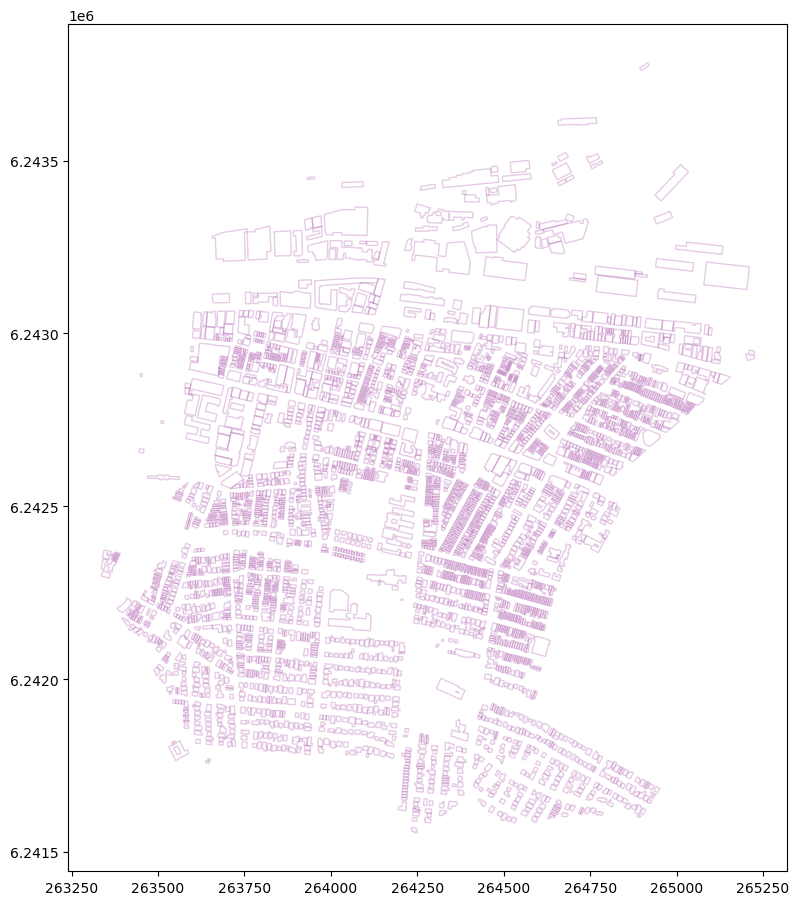

In [23]:
#%matplotlib

#fig, ax = plt.subplots(figsize=(11, 11))
#ts.plot(ax=ax, facecolor='none', edgecolor='purple', alpha=0.2)
#if len(new_df1) > 0:
#    new_df1.plot(ax=ax, edgecolor='red', facecolor='none')#, alpha=0.3)#, column='osm_building', legend=True)

def plot_geometries(df, ax=None, facecolor='none', edgecolor='purple', alpha=0.5):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10,10))

    patches = []

    for geom in df['geometry']:
        if geom is None:
            continue

        if isinstance(geom, Polygon):
            # Exterior ring
            patches.append(MplPolygon(list(geom.exterior.coords), closed=True))
            # Interiors (holes)
            for interior in geom.interiors:
                patches.append(MplPolygon(list(interior.coords), closed=True))
        elif isinstance(geom, MultiPolygon):
            for poly in geom.geoms:
                patches.append(MplPolygon(list(poly.exterior.coords), closed=True))
                for interior in poly.interiors:
                    patches.append(MplPolygon(list(interior.coords), closed=True))

    pc = PatchCollection(patches, facecolor=facecolor, edgecolor=edgecolor, alpha=alpha)
    ax.add_collection(pc)
    ax.autoscale()
    ax.set_aspect('equal')
    return ax

# Example usage:
fig, ax = plt.subplots(figsize=(11, 11))
plot_geometries(ts_copy, ax=ax, facecolor='none', edgecolor='purple', alpha=0.2)
if len(new_df1) > 0:
    plot_geometries(new_df1, ax=ax, facecolor='none', edgecolor='red', alpha=0.5)
#-- save
plt.savefig('./data/topologyFig', dpi=300)
#plt.show()

|  |  |
|:--------:|:--------:|
|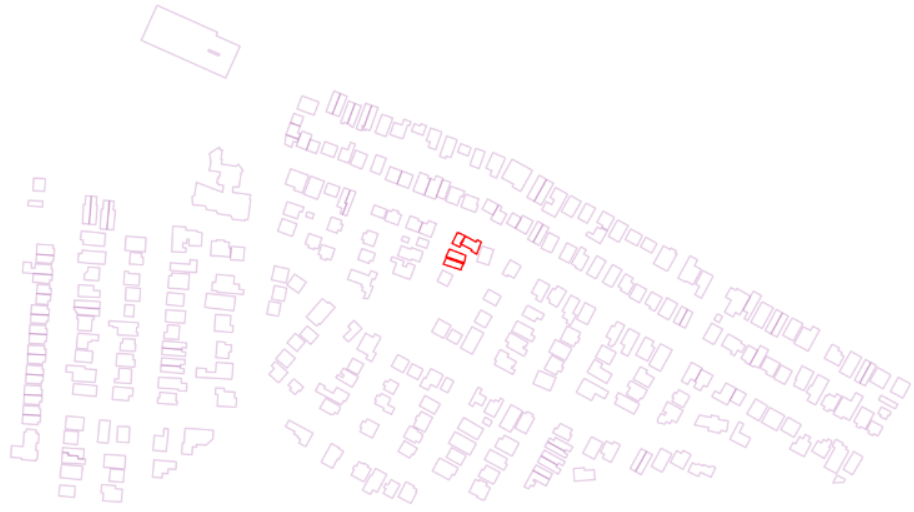 | **Typical challenges will be highlight in *Red*.**|
|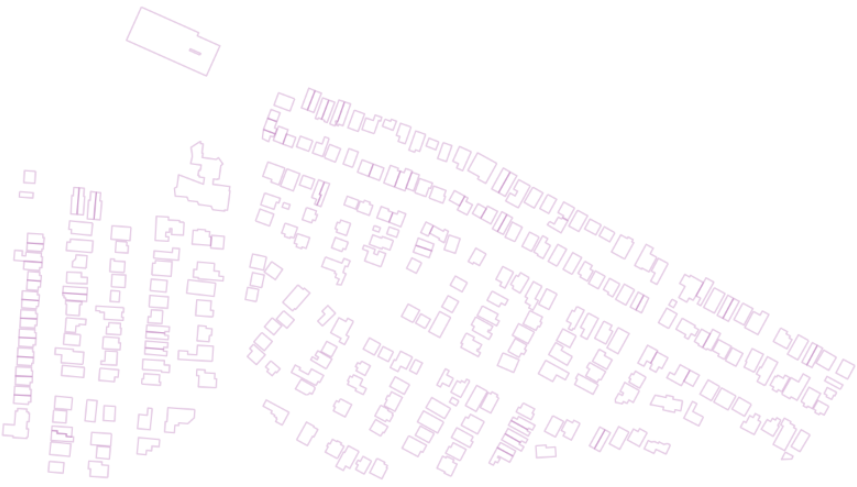| **or none**|
|<br /> **If you continue without fixing the challenges, the LoD1 City Model *will not be error free*.** | <br /> **Our goal is a topologically correct surface.** |

<h2><center>There may still be potential challenges.<br> Please ensure the quality of the value-added product and the source data.</center></h2>

**If necessary; edit [OpenStreetMap](https://www.openstreetmap.org/about) and fix the challenge please.**

<div class="alert alert-block alert-warning"><b></b>
    
And remember.  
Many [Planet.osm mirrors](https://wiki.openstreetmap.org/wiki/Planet.osm) (like the one recommended above) release a ***fresh `.osm.pbf` EVERYDAY!***  
Give the OpenStreetMap server ***at least a day*** before attempting the process again.
    
**Alchemy is a process. Please be patient.**
</div>

In [24]:
#- get the mean height of the bld
ts['mean'] = ts.apply(lambda row: rasterQuery(row.geometry, gt_forward, rb), axis = 1)
ts.head(2)

,amenity,building,craft,historic,leisure,man_made,name,office,osm_id,shop,...,abandoned:building,motorcycle:rental,second_hand,drink:coffee,bus,network,opening_date,unisex,geometry,mean
0,marketplace,retail,None,None,None,None,The Neighbourgoods Market,None,12227309,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MULTIPOLYGON (((265023.4813864499 6242993.3440...,7.17
1,None,apartments,None,None,None,None,Church Square,None,12249345,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MULTIPOLYGON (((264360.39058643614 6242908.633...,10.45


In [25]:
#ts['building:levels'].unique

<div class="alert alert-block alert-warning"><b>Calculate building height:</b> 

We assume a building level is 2.8 meters high and add another 1.3 meters (to account for the roof) and create a new attribute `height`.</div>

The Python code to execute the `.writejson` function is in the `city3D.py` script

In [26]:
# -- execute function. write geoJSON
dis = city3D.process_and_write_geojson(ts, jparams)

In [27]:
start = time.time()
        
dis.drop(dis.index[dis['building'] == 'bridge'], inplace = True)
dis.drop(dis.index[dis['building'] == 'roof'], inplace = True)

#- compute representative point for each geometry
dis["rep_point"] = dis["geometry"].apply(lambda g: g.representative_point() if g else None)
#- extract coordinates
dis["x"] = dis["rep_point"].apply(lambda p: p.x if p else None)
dis["y"] = dis["rep_point"].apply(lambda p: p.y if p else None)
#- drop helper column if you want
dis.drop(columns="rep_point", inplace=True)

hs = dis[['x', 'y', 'ground_height']].copy()


end = time.time()
print('runtime:', str(timedelta(seconds=(end - start))))

runtime: 0:00:00.066187


In [28]:
print(len(dis), 'buildings have been harvested from the osm.pbf for the', jparams["FocusArea"], 'area') 

3708 buildings have been harvested from the osm.pbf for the Woodstock area


In [29]:
#dis.sort_values(by = 'osm_building', inplace=True) 
dis.head(2)
#dis.plot()

,osm_id,address,building,building:levels,building:use,building:flats,building:units,beds,rooms,residential,...,building_height,roof_height,ground_height,bottom_bridge_height,bottom_roof_height,plus_code,footprint,geometry,x,y
0,12227309,The Neighbourgoods Market Woodstock Cape Town,retail,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,4.1,11.27,7.17,NaN,NaN,4FRW3FF5+27C,"(((265023.4813864499, 6242993.344091462), (265...","POLYGON ((265023.4813864499 6242993.344091462,...",265035.863057,6.242978e+06
1,12249345,Church Square 34 Dickson Street 7915 Woodstoc...,apartments,6.0,NaN,105,NaN,NaN,NaN,NaN,...,18.1,28.55,10.45,NaN,NaN,4FRW3FC2+R5G,"(((264360.39058643614, 6242908.633245183), (26...",POLYGON ((264360.39058643614 6242908.633245183...,264327.370820,6.242905e+06


**prepare the elevation for the TIN**

In [30]:
#- 
dis_c = dis.copy()

In [31]:
#- prepare xyz (more buildings = more time)
start = time.time()

# Convert bytes to DataFrame
xyz_str = xyz_bytes.decode("utf-8")  # Decode to string

dtype_spec = {
    "x": np.float32,  # Reduce precision from float64 to float32 (saves memory)
    "y": np.float32,
    "z": np.float32
}

#df = pd.read_csv(jparams['xyz'], delimiter = ' ', header=None, names=["x", "y", "z"])                                                                                
df = pd.read_csv(pd.io.common.StringIO(xyz_str), delimiter=" ",  header=None, 
                 names=["x", "y", "z"], dtype=dtype_spec)                     # in memory fastest

#- Create the shapely 'geometry' column directly (Vectorized) and GeoDataFrameLite | home-baked gdf
df['geometry'] = df.apply(lambda row: Point(row['x'], row['y']), axis=1) 
gdf = city3D.GeoDataFrameLite(df) 
gdf.crs = epsg
#print(len(gdf))

# --- spatial filtering with STRtree (Replacement for GeoPandas overlay) ---
aoi_geom = shapely.unary_union(aoibuffer['geometry'])
dis_geom = shapely.unary_union(dis_c['geometry'])

mask_geom = aoi_geom.symmetric_difference(dis_geom)
# Note: If mask_geom is a Multi-part geometry, we still need unary_union for STRtree query.
# Here we use the .unary_union property on the result to simplify:
#mask_geom = shapely.unary_union(mask_geom['geometry']) 

#- create the spatial index
# This replaces: tree = STRtree(gdf.geometry)
tree = STRtree(gdf['geometry'].values) 

#- tuery the Tree for candidates
possible_matches_indices = tree.query(mask_geom, predicate='intersects')#[0]

#- filter the GeoDataFrameLite to candidate points
df_candidates = gdf.iloc[possible_matches_indices]

#- apply the final, exact .within() filter
gdf = df_candidates[df_candidates['geometry'].apply(lambda geom: geom.within(mask_geom))]

# --- cleanup ---
gdf = gdf[gdf['z'] != jparams['nodata']] 
gdf.reset_index(drop=True, inplace=True)
gdf = gdf.round(2)

end = time.time()
print('runtime:', str(timedelta(seconds=(end - start))))

runtime: 0:03:19.850303


In [32]:
dis.tail(2)

,osm_id,address,building,building:levels,building:use,building:flats,building:units,beds,rooms,residential,...,building_height,roof_height,ground_height,bottom_bridge_height,bottom_roof_height,plus_code,footprint,geometry,x,y
3713,1340498943,Balfour Street Woodstock Cape Town,semidetached_house,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,4.1,60.00,55.900002,NaN,NaN,4FRW3C8X+7VX,"(((264277.10057580634, 6242210.385846458), (26...",POLYGON ((264277.10057580634 6242210.385846458...,264278.217939,6.242203e+06
3714,1423081172,None,warehouse,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,4.1,9.21,5.110000,NaN,NaN,4FRW3CFX+M65,"(((264084.9472572067, 6243146.255961517), (264...","POLYGON ((264084.9472572067 6243146.255961517,...",264104.655982,6.243132e+06


<div class="alert alert-block alert-warning"><b>Prepare for Triangle:</b> </div>

The Python code to execute the `city3D.functions` are in the `city3D.py` script

In [33]:
#- harvest the building vertices. typically the corners. 
ac, c, min_zbld = city3D.getBldVertices(dis, gt_forward, rb)
idx = []
#- segments 
idx, idx01 = city3D.createSgmts(ac, c, gdf, idx)
#- populate the .df with coordinate values (the vertices)
df2 = city3D.concatCoords(gdf, ac)

#- do the same for the area of interest
acoi, ca = city3D.getAOIVertices(aoibuffer, gt_forward, rb)
idx, idx01 = city3D.createSgmts(acoi, ca, df2, idx)
df3 = city3D.concatCoords(df2, acoi)

**Triangle**

In [34]:
pv_pts = df3[['x', 'y', 'z']].values

In [35]:
holes01 = hs[['x', 'y']].round(3).values.tolist()
pts = df3[['x', 'y']].values #, 'z']].values

#the terrain without the blds
A = dict(vertices=pts, segments=idx, holes=holes01)

Tr = tr.triangulate(A, 'p')                  
terrTin = Tr.get('triangles').tolist()

**CityJSON**

In [36]:
#- 
minz = df3['z'].min()
maxz = df3['z'].max()

<div class="alert alert-block alert-warning"><b>create CityJSON</b> </div>

The Python code to execute the `.output_cityjson` function is in the `city3D.py` script

In [37]:
# -- execute function. create CityJSON
crs = epsg[5:]

city3D.output_cityjson(extent, minz, maxz, terrTin, pv_pts, jparams, min_zbld, acoi, crs) 

In [38]:
src_ds = None

<div class="alert alert-block alert-info"><b></b> 

**Go over to [Ninja the online CityJSON viewer](https://ninja.cityjson.org/#) and explore!**

</div>

**You are welcome to further investigate the quality of a 3D Model.**

**The [val3dity](http://geovalidation.bk.tudelft.nl/val3dity/) web app will test CityJSON geometric primitives.**

**If you parse the result of this notebook through [val3dity](http://geovalidation.bk.tudelft.nl/val3dity/) it will return a report with an invalid [TINRelief](https://www.cityjson.org/specs/1.1.1/#tinrelief) and error.**
<br>
<br>
<img src="data/iso19107_error.jpg" width="550"/>
<br>
<br>
**This particular area contains Buildings with courtyards. The courtyards** (polygons) **are islands of terrain disconnected from the *larger* TINRelief** (shell); **thus the error<sup>*</sup>.**
<br>
<br>
<sup>* <sub>***Don't take my word for it. Test and see for yourself!*** `osm3Dsaao_param.json` (South African Royal Observatory, Cape Town) will produce a 100% topologically correct [Open Geospatial Consortium (OGC)](https://www.ogc.org/standard/citygml/) standard LoD1 3D model that conforms to the [ISO 19107 spatial schema for 3D primatives](https://www.iso.org/standard/66175.html) *[connecting and planar surfaces, correct orientation of the surfaces and watertight volumes]*</sub> 

<div class="alert alert-block alert-warning"><b>NOW</b><br><br>


***To understand the value and usefulness of a 3D City Model***; parse the result of this Notebook through [CityJSONspatialDataScience.ipynb](https://github.com/AdrianKriger/geo3D/blob/main/CityJSONspatialDataScience.ipynb) to workthrough an example of:  
- population estimation and
- a calculation of [Building Volume per Capita]((https://www.researchgate.net/publication/343185735_Building_Volume_Per_Capita_BVPC_A_Spatially_Explicit_Measure_of_Inequality_Relevant_to_the_SDGs)
</div>

***As always; you are welcome to raise an issue. I depend on you to help me improve.***

<a id='Section2'></a>

<div class="alert alert-block alert-success"><b>2. Possible Secondary and Tertiary level conversations starters:</b></div>

| **Topic**                                | **Secondary Level Questions**                                                                                                                                                                                   | **Tertiary Level Questions**                                                                                                                                                                                                                   |
|------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **Geography** | - Talk about the main difference between a globe and a map, and why we use map projections to represent the Earth on a flat surface<br>- Explain why different map projections are used for different purposes. For example, why might a Mercator projection be useful for navigation, but not for comparing the sizes of countries? | - Discuss why it is necessary to convert geographic coordinates (latitude and longitude) to a projected coordinate system in the context of the geospatial sciences. What are some potential issues if this conversion is not done? <br>- How does geodesy contribute to the geospatial sciences?|

In [39]:
Tend = time.time()
print('runtime:', str(timedelta(seconds=(Tend - Tstart)))) #previous wStock: 07:09:57

runtime: 0:03:54.025826
